# Baseline 
Baseline solution for VarDial 2022 shared task on Italian Dialect Classification. 

In [1]:
# load the dataset
import pandas as pd
data = pd.read_csv("data/train.csv", ) 

In [2]:
data

,text,label
0,Al funsiòuna da 'l 11 ed novèmber dal 2016.,0
1,Al 2017 'l è 'n an dal XXI sécol dal Calendàr...,0
2,Siligo i è un comun d'la Sardàggna d' 890 abit...,0
3,Valparaisol’é na cmûna e la capitèl d'l sud d'...,0
4,Queschè 'l è 'n elèinc di povéta ch'i àn scrìt...,0
...,...,...
388776,"A pustis, colat dae sas poesias a sas cummèdias.",10
388777,Sa prima cummèdia sua est Sa rebelliòni de is...,10
388778,In su 2010 l'ant torrada a rapresentare.,10
388779,Sa de duas cummèdia est Sa littra de mariedda...,10


In [3]:
X = data['text'].values
y = data['label'].values.astype(int)
print(X.shape, y.shape)

(388781,) (388781,)


Vectorize and scale the training data.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer()
scaler = StandardScaler(with_mean=False)
X = vectorizer.fit_transform(X)
X = scaler.fit_transform(X)

In [5]:
X.shape

(388781, 480442)

Cross-validation k-fold cross validation initialization.

In [6]:
# from sklearn.model_selection import RepeatedKFold

# rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

Train a Logistic Regression classifier with the extracted features.

In [7]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# import numpy as np

# model = LogisticRegression(random_state=0, n_jobs=-1, solver="sag")
# scores = cross_val_score(model, X, y, scoring='f1_micro', cv=rkf, n_jobs=-1)
# print(f'Repeated cross-validation scores: {np.mean(scores)} ({np.std(scores)})')

In [8]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

## Evaluation 

Import devset.

In [9]:
from utils import encode_label

data = pd.read_csv("data/dev.txt", sep = "\t", names=["label", "sample"])
data['label'] = data['label'].apply(encode_label)
data.head(10)

,label,sample
0,6,"Ma te see foeura de coo, ò te me toeuvet in gir?."
1,8,a carni re puvireddi.
2,6,L'era on simpatich tradizional appontament con...
3,9,Chi un tenpo xè stà zovane adesso se consola b...
4,5,"ma òua scià no coménse a fâse do mâ da sôlo, a..."
5,8,"ti lassai sula, comu na varca senza vela, a te..."
6,8,Nun savi 'a sacrificari nenti.
7,8,Na notti chi û senti passari sutta i so
8,9,Da seno a mi me par Che no ghe sia rason de ba...
9,3,Lis ruedis di fat a corevin dentri de cjarador...


Retrain the model on the whole training set.

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, n_jobs=-1, solver="sag")
model.fit(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/cs4nlp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, random_state=0, solver='sag')

Vectorize devset.

In [11]:
X_dev, y_true = data['sample'], data['label']
X_dev = vectorizer.transform(X_dev)
X_dev = scaler.transform(X_dev)

Evaluate predictions with confusion matrix.

In [12]:
y_pred = model.predict(X_dev)

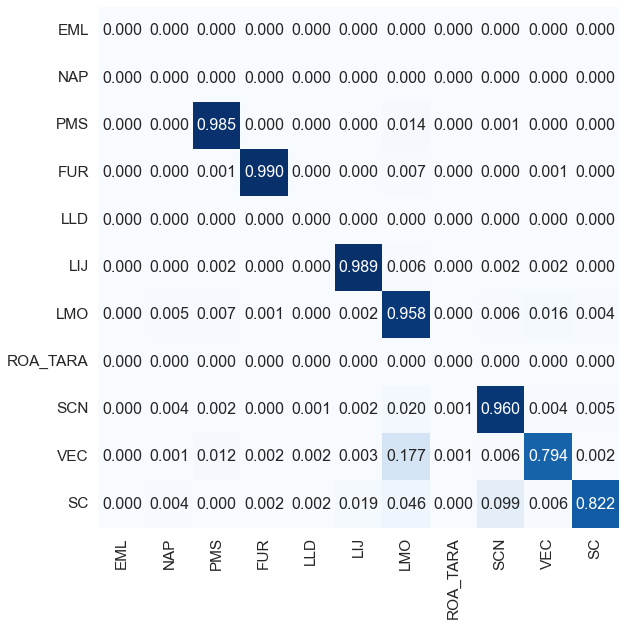

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true", labels=range(0,11))

from utils import explain_label
df_cm = pd.DataFrame(cm, index = [explain_label(i) for i in range(0,11)],
                  columns = [explain_label(i) for i in range(0,11)])

plt.figure(figsize = (9, 9))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 16}, 
            fmt='.3f', 
            cmap="Blues",
            cbar=False) 
plt.tight_layout()  

# plt.savefig('confusion.pdf')
plt.show()

In [14]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average=None)
for score, label in zip(f1, ['EML', 'NAP', 'PMS', 'FUR', 'LLD', 'LIJ', 'LMO', 'ROA_TARA', 'SCN', 'VEC','SC']):
    print(f"{label}: {score}")

EML: 0.0
NAP: 0.980359381529461
PMS: 0.9911111111111112
FUR: 0.0
LLD: 0.9791332263242375
LIJ: 0.8717190388170055
LMO: 0.0
ROA_TARA: 0.9567430025445294
SCN: 0.8727758007117438
VEC: 0.8878822197055494


In [15]:
from utils import explain_label

df = pd.DataFrame(y_pred, columns=["label"])
df['label'] = df['label'].apply(explain_label)
df.to_csv("data/pred.csv", header=None, index=None)

In [16]:
for i, x in enumerate(data['sample']):
    if y_true[i] != y_pred[i]:
        print(x, explain_label(y_true[i]), explain_label(y_pred[i]))

ma lu no 'l la molestava mai per no darghe dispiasser, e el fava da filosofo. VEC LMO
'I addineddi paduvani! SCN LMO
E pà rispeto e amor inparo la to lengoa e sáro in boca la mia. VEC LMO
A chi a casa tra mazza e tuttu z'era cant'e una luscia. SC LMO
Cossa fastu quà? VEC FUR
dopo na note e on giorno de dolor l'è volà in cél. VEC LMO
Anda bè li disi lu tali e da chi z'hani intarratu lu minnannu andesi a pagà e siccommu no aìa meda gana di sbuscià, disi a lu preti: SC SCN
Ma nos ita poteus fai? SC LMO
ghe acordarò che la possa vegnir de suzo, rampegandose per sto poro; VEC LMO
Mi taliasti e mi ricisti: SCN LMO
co sarò Paron de Trogia, mi ve pagarò. VEC LMO
Capisso che l'Atride xe insolente; VEC PMS
Te pioxe i culuri, e só sciùe e só chè, a só poxe, i silensi, te dumandi u perchè. SC LMO
C'è il fisarmonicista accompagnato dalla consor te. LMO SCN
E cosa diesse dizìa pinsamintendi. SC LMO
Anzi, chi ha un parente stipendiato, suo malgrado, dallo Stato, cerca disperatamente di tenerlo nascos

In [17]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# from utils import explain_label
# import numpy as np

# vocab = vectorizer.get_feature_names_out()

# for label in y_true.unique():
#     slicer = y_true == label
#     f = X_dev[slicer]
#     total_freqs = list(np.array(f.sum(axis=0))[0])
#     fdict = dict(zip(vocab,total_freqs))
#     # generate word cloud of words with highest counts
#     wordcloud = WordCloud().generate_from_frequencies(fdict) 
#     print(explain_label(label=label))
#     plt.clf()
#     plt.imshow(wordcloud, interpolation='bilinear') 
#     plt.axis("off") 
#     plt.show()

### Explainability

In [18]:
model.coef_[0].shape

(480442,)

In [19]:
import numpy as np
vocab = vectorizer.get_feature_names_out()
most = []
for i, (sample, X, true, pred) in enumerate(zip(data['sample'], X_dev, y_true, y_pred)):
    
    if true != pred:

        # print(f"## Sample {i} ##")
        # print(sample)
        #vec_feat = np.exp([X_dev[i, feat]*model.coef_[9][feat] for feat in X.indices]) - 1

        wrong_feat = np.exp([X_dev[i, feat]*model.coef_[pred][feat] for feat in X.indices]) - 1
        
        for idx, feat in enumerate(wrong_feat):
            if feat > 0.2:
                most.append((i, vocab[X.indices[idx]], explain_label(pred), explain_label(true), feat))

        # print(ind)
        # print([vocab[feat] for feat in X.indices])
        # print("VEC", vec_feat)
        # print("LMO", lmo_feat, "\n")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
expl_df = pd.DataFrame(most, columns=['sample', 'word', 'pred', 'true', 'dev']).groupby(['word', 'pred', 'true']).agg(['unique'])


expl_df['sample', 'unique'] = expl_df['sample', 'unique'].apply(lambda x: x if len(x)>5 else np.nan)
expl_df.dropna(inplace=True)

expl_df

,,,sample,dev
,,,unique,unique
word,pred,true,,
anca,LMO,VEC,"[2839, 3071, 3508, 5240, 5262, 6766]","[0.8863015483630874, 0.5001520465029299, 0.376097053661665, 0.31027886350537237, 0.2381458663654945, 0.31473277735822935]"
ben,LMO,VEC,"[522, 566, 678, 4310, 5762, 6164, 6495]","[0.3100954521483157, 0.24062104525383665, 0.20988975262285758, 0.22878270047857696, 0.2200120157784582, 0.32823235734210043, 0.2756037147649153]"
che,LMO,VEC,"[134, 323, 481, 515, 678, 711, 725, 1057, 1700, 2223, 2224, 2298, 2368, 2537, 2964, 3071, 3111, 3382, 3874, 3879, 4035, 4078, 4305, 4307, 4310, 4446, 4655, 4944, 5262, 5544, 5655, 5673, 6164, 6258, 6346, 6371, 6495, 6590, 6743]","[0.2294192984543686, 0.293918314320448, 0.2674357775085072, 0.20549231575889926, 0.23225943412556904, 0.20150703346410048, 0.21732047849344704, 0.24309812272784237, 0.27321995158708545, 0.40791779446969456, 0.2148190771713625, 0.20215084978216846, 0.264427049370223, 0.24633849543399222, 0.20278924044391178, 0.30637901970770653, 0.2521121042632313, 0.2049061078024188, 0.2696783521188313, 0.3458837694602883, 0.3414993921536169, 0.27549971154996045, 0.20595792067959584, 0.35944660644724147, 0.253367678769826, 0.22359896044787675, 0.4004610850388286, 0.3964898566471866, 0.32516234143333667, 0.38919635055387647, 0.2667744740039175, 0.20744792229368092, 0.3649834012478681, 0.7047677214085266, 0.24030036785122744, 0.3762357295781755, 0.3058123980131098, 0.2466053958990846, 0.2925866429539812]"
cossa,LMO,VEC,"[259, 1002, 1233, 1700, 4035, 4307, 4492, 4834, 5451, 6480]","[1.1024628511760537, 1.0832271334139216, 0.7074973702770004, 0.7921975318208763, 0.4259106419687695, 1.099547188651846, 1.0474050808120432, 1.4020939431471113, 0.70386913425672, 0.8465371612817845]"
del,LMO,VEC,"[671, 687, 2279, 3864, 5240, 5655, 6287]","[0.2349075941486749, 0.46476435548146067, 0.22846689351353788, 0.2714041161660301, 0.30449243631812006, 0.4232919687658696, 0.25077943717131235]"
di,SCN,SC,"[322, 675, 696, 1264, 1304, 1327, 3291, 3856, 4205, 4287, 4296, 4401, 5359, 5379, 5816]","[0.2838853151024656, 0.9180684668182455, 0.3006983727479111, 0.48314887754297065, 0.25414565481903906, 0.3403997907660392, 0.3518200868773409, 0.3233205077035648, 0.7679037939574103, 0.20760242333175305, 0.30265495409027854, 0.5471165141979346, 0.8170990118281436, 0.2624807488847334, 0.48638718575283635]"
dui,SCN,SC,"[187, 265, 1304, 1988, 3856, 4287, 5379]","[0.4332823114080575, 0.6694608393023358, 0.5789698621259673, 0.5784764143905989, 0.3264866639958879, 0.46300439864313736, 1.0242527637481533]"
el,LMO,VEC,"[259, 453, 481, 717, 953, 1043, 1484, 1712, 2674, 3071, 3547, 4532, 4536, 5171, 5636, 5673]","[0.2414832330543697, 0.2399517578995991, 0.3955074644587735, 0.5686747106531655, 0.2074238886653763, 0.20897447647191658, 0.5708374210327714, 0.2963297814876056, 0.27065951727528614, 0.20672119790186128, 0.3045214236073457, 0.3452746416603545, 0.28711095952532806, 0.23491763723039116, 0.2293126180973304, 0.3035314304061383]"


### Dev feature space visualization with PCA and t-SNE

In [20]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=1000)
data = pca.fit_transform(X_dev)

In [21]:
import numpy as np
np.sum(pca.explained_variance_ratio_)

0.6871873601901386

In [22]:
from sklearn.manifold import TSNE

tnse = TSNE(n_components=2, n_iter=3000, metric='cosine', n_jobs=-1, init='random', learning_rate='auto', square_distances='legacy')
X_embedded = tnse.fit_transform(data)

/opt/homebrew/Caskroom/miniforge/base/envs/cs4nlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Text(0.5, 1.0, '')

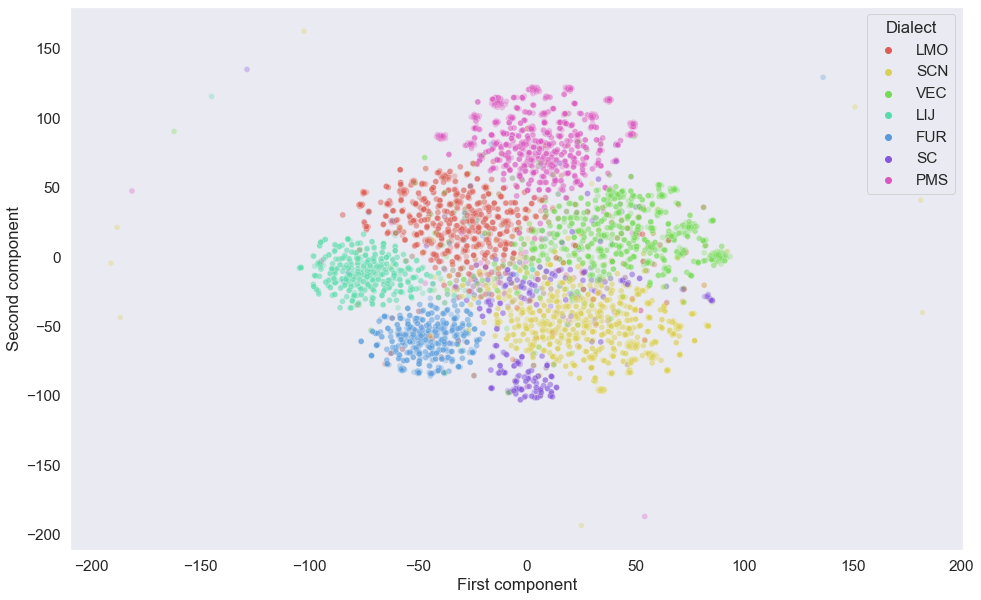

In [23]:
import seaborn as sns
sns.axes_style("whitegrid")

df = pd.DataFrame()
df['tsne-2d-one'] = X_embedded[:,0]
df['tsne-2d-two'] = X_embedded[:,1]
df['Dialect'] = y_true
from utils import explain_label
df['Dialect'] = df['Dialect'].apply(explain_label)

fig = plt.figure(figsize = (16,10))

targets = ['EML', 'NAP', 'PMS', 'FUR', 'LLD', 'LIJ', 'LMO', 'ROA_TARA', 'SCN', 'VEC','SC']

ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Dialect",
    palette=sns.color_palette("hls", 7),
    data=df,
    legend=targets,
    alpha=0.3    
)

ax.grid(False)
#ax.set(xticklabels=[], yticklabels=[])
ax.set(xlabel='First component', ylabel='Second component')
ax.set_title(label='')